# ---------------------------------- 🤓 HACKATON IA 2023 🤖 -----------------------------------

#### 🐱‍👤 Revisamos que la GPU funcione (checkear kernel de Anaconda Env)

In [32]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


---

### 🐱‍👤 Comenzamos analizando nuestro dataset de imágenes

In [33]:
from keras.datasets import mnist
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from keras.models import Sequential
from keras.layers import Dense, Flatten
import openpyxl

In [34]:
classes = [f for f in os.listdir('movie_dataset/train')]
print(classes)

['El caballero oscuro', 'El padrino', 'El señor de los anillos El retorno del rey', 'Titanic']


In [35]:
#Exploramos las carpetas...
import os
for dir, dirname, files in os.walk('movie_dataset'):
  print(f"Dir: {dir} | subdir: {dirname} | cant de imagenes: {len(files)} ")

Dir: movie_dataset | subdir: ['test', 'train'] | cant de imagenes: 0 
Dir: movie_dataset\test | subdir: ['El caballero oscuro', 'El padrino', 'El señor de los anillos El retorno del rey', 'Titanic'] | cant de imagenes: 0 
Dir: movie_dataset\test\El caballero oscuro | subdir: [] | cant de imagenes: 250 
Dir: movie_dataset\test\El padrino | subdir: [] | cant de imagenes: 250 
Dir: movie_dataset\test\El señor de los anillos El retorno del rey | subdir: [] | cant de imagenes: 250 
Dir: movie_dataset\test\Titanic | subdir: [] | cant de imagenes: 250 
Dir: movie_dataset\train | subdir: ['El caballero oscuro', 'El padrino', 'El señor de los anillos El retorno del rey', 'Titanic'] | cant de imagenes: 0 
Dir: movie_dataset\train\El caballero oscuro | subdir: [] | cant de imagenes: 250 
Dir: movie_dataset\train\El padrino | subdir: [] | cant de imagenes: 250 
Dir: movie_dataset\train\El señor de los anillos El retorno del rey | subdir: [] | cant de imagenes: 250 
Dir: movie_dataset\train\Titanic

In [36]:
classes = [f for f in os.listdir('movie_dataset/train')]
print(classes)

['El caballero oscuro', 'El padrino', 'El señor de los anillos El retorno del rey', 'Titanic']


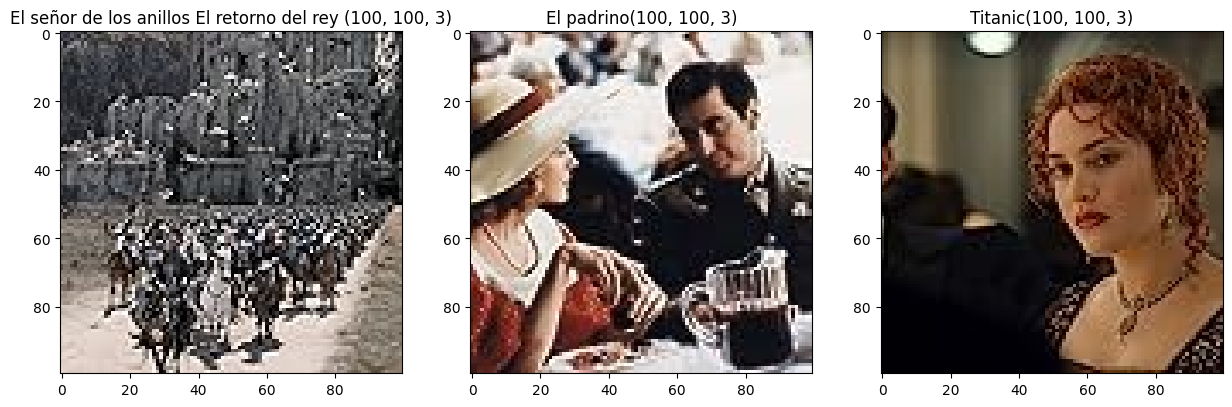

In [37]:
import matplotlib.pyplot as plt
import random, os

plt.figure(figsize=(15,7))
id = random.choice(range(0,16))
plt.subplot(1,3,1)
img_name = [f for f in os.listdir('movie_dataset/train/El señor de los anillos El retorno del rey/')][id]
img = plt.imread('movie_dataset/train/El señor de los anillos El retorno del rey/'+img_name)
plt.imshow(img)
plt.title('El señor de los anillos El retorno del rey '+str(img.shape))
plt.subplot(1,3,2)
img_name = [f for f in os.listdir('movie_dataset/train/El padrino/')][id]
img = plt.imread('movie_dataset/train/El padrino/'+img_name)
plt.imshow(img)
plt.title('El padrino'+str(img.shape))
plt.subplot(1,3,3)
img_name = [f for f in os.listdir('movie_dataset/train/Titanic/')][id]
img = plt.imread('movie_dataset/train/Titanic/'+img_name)
plt.imshow(img)
plt.title('Titanic'+str(img.shape));

In [38]:
#Exploramos los características de las imágenes
list_img_film = [f for f in os.listdir('movie_dataset/train/Titanic')]
test_img = plt.imread('movie_dataset/train/Titanic/'+random.choice(list_img_film)) #Elegimos la primera de las imágenes de la lista para leerlas
print(f"Shape de la imagen: {test_img.shape}")
print(f"Dimensiones de la imagen: {test_img.ndim}")
print(f"Codificación la imagen: {test_img.dtype}")
print(f"Pixel de mayor valor: {test_img.max()}")
print(f"Pixel de menor valor: {test_img.min()}")

Shape de la imagen: (100, 100, 3)
Dimensiones de la imagen: 3
Codificación la imagen: uint8
Pixel de mayor valor: 255
Pixel de menor valor: 0


In [39]:
import tensorflow as tf
print(f"Version: {tf.version}")

Version: <module 'tensorflow._api.v2.version' from 'c:\\Users\\aaron\\anaconda3\\envs\\tf-gpu\\lib\\site-packages\\tensorflow\\_api\\v2\\version\\__init__.py'>


---

## 🐱‍👤 1- Entrenamos el Nuestro propio Modelo CNN

In [40]:
import tensorflow as tf

# Configuración de la semilla aleatoria para reproducibilidad
tf.random.set_seed(42)

# Directorios de entrenamiento y prueba
train_dir = 'movie_dataset/train/'
test_dir = 'movie_dataset/test/'

# Data augmentation
# Generadores de datos de entrenamiento y prueba con normalización y aumento de datos
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=30,       # Aumento de rotación
    width_shift_range=0.2,   # Aumento de cambio de ancho
    height_shift_range=0.2,  # Aumento de cambio de alto
    shear_range=0.2,         # Distorción
    zoom_range=0.2           # Aumento de zoom
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_batch = train_generator.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=240,
    class_mode='categorical'
)

test_batch = test_generator.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=240,
    class_mode='categorical'
)

Found 1000 images belonging to 4 classes.


Found 1000 images belonging to 4 classes.


In [41]:
model_cnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32,(3,3), activation='relu', input_shape=(224,224,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128,(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
 
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 26, 26, 128)     

In [42]:
# Compilación del modelo
model_cnn.compile(
    optimizer=tf.keras.optimizers.Adam(), #learning_rate=0.0001
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

In [43]:
from tensorflow.keras.callbacks import TensorBoard

In [44]:
# Entrenamiento del modelo
tensorboardDenso = TensorBoard(log_dir='logs')
model_cnn.fit(
    train_batch,
    epochs=200,
    validation_data=test_batch,
    callbacks=[
        tensorboardDenso,
        tf.keras.callbacks.EarlyStopping(patience=10),
        tf.keras.callbacks.ReduceLROnPlateau(patience=5)
    ]
)

# Evaluación del modelo en el conjunto de prueba
test_accuracy = model_cnn.evaluate(test_batch)

Epoch 1/200
5/5 [==============================] - 18s 3s/step - loss: 2.2379 - accuracy: 0.2350 - val_loss: 1.4238 - val_accuracy: 0.2500 - lr: 0.0010
Epoch 2/200
5/5 [==============================] - 17s 3s/step - loss: 1.3869 - accuracy: 0.2490 - val_loss: 1.3882 - val_accuracy: 0.2810 - lr: 0.0010
Epoch 3/200
5/5 [==============================] - 15s 3s/step - loss: 1.3665 - accuracy: 0.3550 - val_loss: 1.3566 - val_accuracy: 0.3780 - lr: 0.0010
Epoch 4/200
5/5 [==============================] - 15s 4s/step - loss: 1.3404 - accuracy: 0.3560 - val_loss: 1.3007 - val_accuracy: 0.3650 - lr: 0.0010
Epoch 5/200
5/5 [==============================] - 17s 3s/step - loss: 1.2885 - accuracy: 0.4130 - val_loss: 1.2232 - val_accuracy: 0.4740 - lr: 0.0010
Epoch 6/200
5/5 [==============================] - 21s 3s/step - loss: 1.2244 - accuracy: 0.4890 - val_loss: 1.2575 - val_accuracy: 0.4440 - lr: 0.0010
Epoch 7/200
5/5 [==============================] - 18s 3s/step - loss: 1.2147 - accuracy

#### 🐱‍👤 Luego del entrenamiento, guardamos nuestro modelo en formato json para poder usarlo en nuestra webapp con ayuda del modulo TensorflowJS!

In [45]:
model_transfer.save('films_classifier_cnn.h5')

In [46]:
from tensorflow.keras.models import load_model

loaded_model = load_model('films_classifier_cnn.h5')

In [47]:
mkdir output_directory_cnn

In [48]:
!tensorflowjs_converter --input_format keras films_classifier_cnn.h5 output_directory_cnn

---

### 🐱‍👤 Antes de evaluar nuestro modelo, usaremos nuestro dataset con un modelo pre-entrenado como es el de MobileNetV2, para poder compararlos al final!

In [62]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2

# Configuración de la semilla aleatoria para reproducibilidad
tf.random.set_seed(42)

# Directorios de entrenamiento y prueba
train_dir = 'movie_dataset/train/'
test_dir = 'movie_dataset/test/'

# Data augmentation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Cargar el modelo pre-entrenado MobileNetV2 sin incluir la capa superior
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Congelar las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

# Agregar capas adicionales para la clasificación de películas
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(256, activation='relu')(x)
predictions = tf.keras.layers.Dense(4, activation='softmax')(x)

model_transfer = tf.keras.Model(inputs=base_model.input, outputs=predictions)

# Compilación del modelo
model_transfer.compile(
    optimizer=tf.keras.optimizers.Adam(), #learning_rate=0.0001
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Entrenamiento del modelo
train_batch = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_batch = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

model_transfer.fit(
    train_batch,
    epochs=200,
    validation_data=test_batch,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=10),
        tf.keras.callbacks.ReduceLROnPlateau(patience=5)
    ]
)

# Evaluación del modelo en el conjunto de prueba
test_accuracy = model_transfer.evaluate(test_batch, verbose=2)


Found 1000 images belonging to 4 classes.
Found 1000 images belonging to 4 classes.
Epoch 1/200
32/32 [==============================] - 25s 610ms/step - loss: 1.2307 - accuracy: 0.4790 - val_loss: 0.9397 - val_accuracy: 0.6050 - lr: 0.0010
Epoch 2/200
32/32 [==============================] - 16s 477ms/step - loss: 0.6878 - accuracy: 0.7250 - val_loss: 0.9157 - val_accuracy: 0.6230 - lr: 0.0010
Epoch 3/200
32/32 [==============================] - 18s 559ms/step - loss: 0.5414 - accuracy: 0.7990 - val_loss: 0.6810 - val_accuracy: 0.7170 - lr: 0.0010
Epoch 4/200
32/32 [==============================] - 16s 498ms/step - loss: 0.4372 - accuracy: 0.8320 - val_loss: 0.5846 - val_accuracy: 0.7580 - lr: 0.0010
Epoch 5/200
32/32 [==============================] - 16s 486ms/step - loss: 0.4101 - accuracy: 0.8610 - val_loss: 0.5863 - val_accuracy: 0.7450 - lr: 0.0010
Epoch 6/200
32/32 [==============================] - 15s 483ms/step - loss: 0.3161 - accuracy: 0.8830 - val_loss: 0.4420 - val_accu

#### 🐱‍👤 Otra vez, volvemos a darle formato y guardar el segundo modelo.

In [63]:
model_transfer.save('films_classifier_mobilenet.h5')

In [64]:
from tensorflow.keras.models import load_model

loaded_model = load_model('films_classifier_mobilenet.h5')

In [65]:
mkdir output_directory_mobilenet

Ya existe el subdirectorio o el archivo output_directory_mobilenet.


In [66]:
!tensorflowjs_converter --input_format keras films_classifier_mobilenet.h5 output_directory_mobilenet

#### 🐱‍👤 Ahora si, instanciaremos también nuestro dashboard para poder ver las estadísticas y haremos unas predicciones simples!

In [67]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [75]:
# Realizamos una predicción de CNN

# Elegimos una imagen de prueba
img = plt.imread(r'movie_dataset\test\El padrino\252.jpg')

# Reescalamos la imagen para introducirla al modelo
img = img/255.

# Ajustamos las dimensiones de la imagen
img.resize((224,224,3))
img_exp = tf.expand_dims(img, axis=0)

y_pred = model_cnn.predict(img_exp)
print(f"Predicción: {y_pred}") # Softmax

1/1 [==============================] - 0s 52ms/step
Predicción: [[9.9999809e-01 1.8950745e-06 2.3926761e-10 1.6745759e-08]]


In [69]:
y_pred = tf.squeeze(y_pred)
tf.math.reduce_sum(y_pred).numpy()

1.0

In [70]:
tf.argmax(y_pred).numpy()

0

In [71]:
y_pred = tf.squeeze(y_pred)
y_pred = tf.round(y_pred)
print(f"Predicción de la imagen: {y_pred}") # Argmax

Predicción de la imagen: [1. 0. 0. 0.]


In [72]:
# Retornar el indice mayor de todos los items
y_pred = tf.argmax(y_pred)
print(f"La clase es: {classes[y_pred]}")

La clase es: El caballero oscuro


In [73]:
# Realizamos una otra predicción CNN

from tensorflow.keras.preprocessing import image

test_image_path = r'movie_dataset\test\El señor de los anillos El retorno del rey\262.jpg'

test_image = image.load_img(test_image_path, target_size=(224, 224))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
test_image = test_image / 255.0  # Normalizar la imagen

predictions = model_cnn.predict(test_image)

class_labels = ['El caballero oscuro', 'El padrino', 'El señor de los anillos: El retorno del rey', 'Titanic']
predicted_class = class_labels[np.argmax(predictions)]

print(f'Predicción: {predicted_class}')

1/1 [==============================] - 0s 137ms/step
Predicción: El señor de los anillos: El retorno del rey


In [74]:
# Realizamos una predicción MobileNetV2
import numpy as np
from tensorflow.keras.preprocessing import image

test_image_path = r'movie_dataset\test\El señor de los anillos El retorno del rey\262.jpg'

test_image = image.load_img(test_image_path, target_size=(224, 224))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
test_image = test_image / 255.0  # Normalizar la imagen

predictions = model_transfer.predict(test_image)

class_labels = ['El caballero oscuro', 'El padrino', 'El señor de los anillos: El retorno del rey', 'Titanic']
predicted_class = class_labels[np.argmax(predictions)]

print(f'Predicción: {predicted_class}')

1/1 [==============================] - 2s 2s/step
Predicción: El caballero oscuro


#### 🐱‍👤 Al parecer el segundo modelo está teniendo problemas para identificar nuestras peliculas... 🤭🤨 Pero qué pasará si usamos nuevas imágenes? Averiguemoslo con la APP!! 🤑